### 桃園市政府勞動局 109 年勞工學苑產業應用班
### 人工智慧深度學習技術實作班
# 第 11 單元：以 TensorFlow 處理迴歸問題

### 林柏江老師
元智大學 電機工程學系 助理教授

元智大學 科學教育研究中心 副主任

元智大學 教務處 教學服務組 組長

Email: pclin@saturn.yzu.edu.tw

## 大綱
1. 神經網路訓練步驟
2. Kaggle 介紹
3. 實驗一：房價預測模型
4. TensorBoard 可視化工具介紹
5. 實驗二：處理過擬合問題

## 1. 神經網路訓練步驟
1. 準備訓練資料 (training data)，分為訓練的輸入資料以及預期輸出的標記答案。
2. 搭建神經網路模型 (model)，用來預測數值。
3. 損失函數 (loss function) 計算模型預測與標記答案之間的誤差。
    - 這個單元使用均方誤差 (Mean Square Error) 作為損失函數。
4. 優化器 (optimizer) 決定學習過程如何進行。
    - 這個單元使用 Adam 優化器。
5. 準備驗證資料 (validation data) 和測試資料 (testing data) 來讓模型做預測，並透過指標函數 (metric function) 來評估模型的好壞。
    - 驗證資料 (validation data)：作為調整超參數 (網路層數、神經元數目、batch 大小、學習率、訓練週期等) 以獲得最佳模型的依據。
    - 測試資料 (testing data)：作為最後評估模型的主要依據。

## 2. [Kaggle](https://www.kaggle.com/) 介紹
- 資料科學 / 機器學習領域的程式碼以及資料集平台。
- 產業界、學術界都可以在上面發布資料集、或是舉辦競賽。
- 有許多資料集已整理完成並提供下載。
- 鼓勵討論與分享成果的社群平台。

## 3. 實驗一：房價預測模型
- 希望透過神經網路模型來預測房屋的價格。
- 輸入為房屋的資訊，例如坪數、樓層、房齡等。
- 輸出為房屋的價格。

**實驗一：房價預測模型的資料集**
- 我們使用 Kaggle 的 [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction) 資料集。
- 下載後請解壓縮，把 kc_house_data.csv 檔案移動到本程式所在目錄。

**Import 必要套件**

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# 檢查 TensorFlow 可用設備
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

**數據讀取並分析**

In [3]:
data = pd.read_csv("kc_house_data.csv")
# 顯示 dataset 的形狀，共 21,613 筆資料，每一筆資料有 21 種不同資訊。
data.shape

(21613, 21)

In [4]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


各個欄位的說明：
- date：房屋出售日期。
- price：房屋價格（目標）。
- bedrooms：臥室數量。
- bathrooms：浴室數量。
- sqft_living：居住的坪數（平方英尺）。
- sqft_lot：實際的坪數（平方英尺）。
- floors：房屋總共樓層。
- waterfront：海景房。
- view：房屋是否看過。
- condition：整體條件有多好。

各個欄位的說明 (續)：
- grade：房屋的整體等級（根據 King County 評分系統）。
- sqft_above：除了地下室外的坪數（平方英尺）。
- sqft_basement：地下室的坪數（平方英尺）。
- yr_built：房屋建造時間。
- yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。
- zipcode：郵政編碼。
- lat：緯度座標。
- long：經度座標。
- sqft_living15：2015 年紀錄的居住坪數（可能是翻新的原因導致  sqft_living15  與sqft_living 不同）。
- sqft_lot15：2015 年紀錄的實際坪數（可能是翻新的原因導致 sqft_lot15 與 sqft_lot 不同）。

**檢查資料的型態**

資料型態總共有五種：object (string), boolean, integer, float, 以及 categorical。

In [5]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

**數據前處理**

轉換資料型態：
因為數據集裡的 date 數據是字串 (string) 格式，而模型的輸入只接受數值格式，所以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [6]:
# 將 date 日期拆為年、月和日並轉成數值
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除沒有用的數據，inplace 則是將更新後的資料存回原本的地方
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集 (dataset)：將數據集切割成三個部份，訓練數據 (training data)、驗證數據 (validation data)、以及測試數據 (testing data)。

In [7]:
data_num = data.shape[0]
# 取得一筆與 data 數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為 train、validation 和 test，這裡的劃分比例為 6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從 data 取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

**Normalization 正規化**

使用標準分數 (Standard Score, 又稱 z-score) 把資料正規化，經過 z-score 正規化後，資料平均值為 0，標準差為 1。 

(x - 平均值) / 標準差

In [8]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

**建立  Numpy array 格式的訓練資料與驗證資料**

In [9]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])

整理過後的訓練資料共 12,967 筆，且一筆資料有 21 種資訊 (所以網路輸入必須為 21)。

In [10]:
x_train.shape

(12967, 21)

**建立並訓練網路模型**

這裡建構三層全連接層的網路架構，並且使用  ReLU作為隱藏層的激活函數，而由於需得到線性輸出，故輸出層不使用任何激活函數。

In [11]:
# 建立一個 Sequential 型態的 model
model = keras.Sequential(name='model-1')
# 第 1 層全連接層設為 64 個 unit，將輸入形狀設定為 (21, )，而實際上我們輸入的數據形狀為 (batch_size, 21)
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))
# 第 2 層全連接層設為 64 個 unit
model.add(layers.Dense(64, activation='relu'))
# 最後一層全連接層設為 1 個 unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數：

In [12]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

創建模型儲存目錄：

In [13]:
import shutil

model_dir = 'lab2-logs/models/'

while os.path.isdir(model_dir):
    shutil.rmtree(model_dir)
    time.sleep(5)

os.makedirs(model_dir)

設定回調函數：

In [14]:
# TensorBoard 回調函數會幫忙紀錄訓練資訊，並存成 TensorBoard 的紀錄檔
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint 回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min 則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                        monitor='val_mean_absolute_error', 
                                        save_best_only=True, 
                                        mode='min')

訓練網路模型：

In [15]:
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為 64
               epochs=300,  # 整個 dataset 訓練 300 遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard 回調函數紀錄訓練過程，ModelCheckpoint 回調函數儲存最好的模型

300
12967/12967 [==============================] - 1s 51us/sample - loss: 0.0317 - mean_absolute_error: 0.1310 - val_loss: 0.1216 - val_mean_absolute_error: 0.2085
Epoch 187/300
12967/12967 [==============================] - 1s 50us/sample - loss: 0.0306 - mean_absolute_error: 0.1291 - val_loss: 0.1206 - val_mean_absolute_error: 0.2046
Epoch 188/300
12967/12967 [==============================] - 1s 53us/sample - loss: 0.0314 - mean_absolute_error: 0.1300 - val_loss: 0.1219 - val_mean_absolute_error: 0.2047
Epoch 189/300
12967/12967 [==============================] - 1s 53us/sample - loss: 0.0305 - mean_absolute_error: 0.1285 - val_loss: 0.1300 - val_mean_absolute_error: 0.2111
Epoch 190/300
12967/12967 [==============================] - 1s 51us/sample - loss: 0.0324 - mean_absolute_error: 0.1312 - val_loss: 0.1230 - val_mean_absolute_error: 0.2061
Epoch 191/300
12967/12967 [==============================] - 1s 50us/sample - loss: 0.0321 - mean_absolute_error: 0.1307 - val_loss: 0.1316 

**訓練結果**

In [16]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

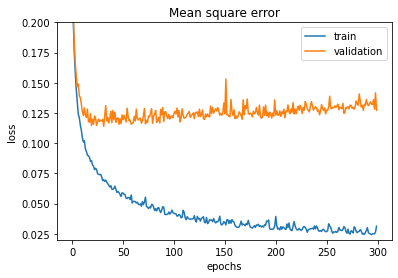

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

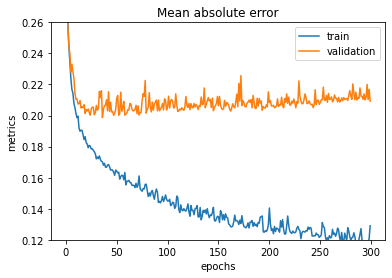

In [18]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

測試數據的誤差百分比：用測試數據預測房屋價格並與答案計算誤差百分比。

In [19]:
# 載入模型
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測測試數據
y_pred = model.predict(x_test)
# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

Model_1 Percentage Error: 13.67%


## 4. TensorBoard 可視化工具介紹

**方法一：使用 Jupyter Notebook**

In [20]:
# 這行指令可以幫助我們直接在jupyter notebook上顯示TensorBoard
# %load_ext tensorboard
%reload_ext tensorboard

In [21]:
# 執行 TensorBoard，並指定記錄檔資料夾為 lab2-logs
%tensorboard --logdir lab2-logs
# 也可以指定 port
# %tensorboard --port 9530 --logdir lab2-logs

Reusing TensorBoard on port 6006 (pid 8128), started 1 day, 23:55:57 ago. (Use '!kill 8128' to kill it.)

**方法二：使用 command line**

執行以下指令：

```tensorboard --logdir lab2-logs```

再使用網路瀏覽器連線到 http://localhost:6006/

也可以指定 port：

```tensorboard --port 9530 --logdir lab2-logs```

## 5. 實驗二：處理過擬合問題

**方法一、縮減網路權重**

In [22]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(21,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')

In [23]:
model_2.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

300
12967/12967 [==============================] - 1s 48us/sample - loss: 0.0788 - mean_absolute_error: 0.1836 - val_loss: 0.1173 - val_mean_absolute_error: 0.2056
Epoch 187/300
12967/12967 [==============================] - 1s 49us/sample - loss: 0.0788 - mean_absolute_error: 0.1837 - val_loss: 0.1150 - val_mean_absolute_error: 0.2035
Epoch 188/300
12967/12967 [==============================] - 1s 49us/sample - loss: 0.0798 - mean_absolute_error: 0.1838 - val_loss: 0.1190 - val_mean_absolute_error: 0.2097
Epoch 189/300
12967/12967 [==============================] - 1s 50us/sample - loss: 0.0790 - mean_absolute_error: 0.1842 - val_loss: 0.1179 - val_mean_absolute_error: 0.2063
Epoch 190/300
12967/12967 [==============================] - 1s 49us/sample - loss: 0.0790 - mean_absolute_error: 0.1838 - val_loss: 0.1155 - val_mean_absolute_error: 0.2031
Epoch 191/300
12967/12967 [==============================] - 1s 49us/sample - loss: 0.0783 - mean_absolute_error: 0.1840 - val_loss: 0.1133 

**加入權重正規化**

L1 或 L2 正則化

In [24]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, 
                         kernel_regularizer=keras.regularizers.l2(0.001), 
                         activation='relu', input_shape=(21,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')

In [25]:
model_3.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

300
12967/12967 [==============================] - 1s 49us/sample - loss: 0.0731 - mean_absolute_error: 0.1573 - val_loss: 0.1221 - val_mean_absolute_error: 0.1871
Epoch 187/300
12967/12967 [==============================] - 1s 50us/sample - loss: 0.0725 - mean_absolute_error: 0.1557 - val_loss: 0.1180 - val_mean_absolute_error: 0.1877
Epoch 188/300
12967/12967 [==============================] - 1s 49us/sample - loss: 0.0762 - mean_absolute_error: 0.1604 - val_loss: 0.1257 - val_mean_absolute_error: 0.1885
Epoch 189/300
12967/12967 [==============================] - 1s 48us/sample - loss: 0.0771 - mean_absolute_error: 0.1607 - val_loss: 0.1266 - val_mean_absolute_error: 0.1886
Epoch 190/300
12967/12967 [==============================] - 1s 49us/sample - loss: 0.0814 - mean_absolute_error: 0.1617 - val_loss: 0.1282 - val_mean_absolute_error: 0.1942
Epoch 191/300
12967/12967 [==============================] - 1s 49us/sample - loss: 0.0757 - mean_absolute_error: 0.1598 - val_loss: 0.1197 

**加入 Dropout**

In [26]:
model_4 = keras.Sequential(name='model-4')
model_4.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(1))

model_4.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')

In [27]:
model_4.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

300
12967/12967 [==============================] - 1s 53us/sample - loss: 0.1092 - mean_absolute_error: 0.2140 - val_loss: 0.1181 - val_mean_absolute_error: 0.2171
Epoch 187/300
12967/12967 [==============================] - 1s 53us/sample - loss: 0.1143 - mean_absolute_error: 0.2171 - val_loss: 0.1221 - val_mean_absolute_error: 0.2152
Epoch 188/300
12967/12967 [==============================] - 1s 53us/sample - loss: 0.1193 - mean_absolute_error: 0.2157 - val_loss: 0.1117 - val_mean_absolute_error: 0.2141
Epoch 189/300
12967/12967 [==============================] - 1s 53us/sample - loss: 0.1241 - mean_absolute_error: 0.2180 - val_loss: 0.1360 - val_mean_absolute_error: 0.2306
Epoch 190/300
12967/12967 [==============================] - 1s 54us/sample - loss: 0.1100 - mean_absolute_error: 0.2155 - val_loss: 0.1096 - val_mean_absolute_error: 0.2059
Epoch 191/300
12967/12967 [==============================] - 1s 53us/sample - loss: 0.1105 - mean_absolute_error: 0.2138 - val_loss: 0.1316 

**驗證正則化的效能**

Test model 2:

In [28]:
model_2 = keras.models.load_model('lab2-logs/models/Best-model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_2: {:.2f}%".format(percentage_error))

Model_2: 13.83%


Test model 3:

In [29]:
model_3 = keras.models.load_model('lab2-logs/models/Best-model-3.h5')
y_pred = model_3.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_3: {:.2f}%".format(percentage_error))

Model_3: 12.92%


Test model 4:

In [30]:
model_4 = keras.models.load_model('lab2-logs/models/Best-model-4.h5')
y_pred = model_4.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_4: {:.2f}%".format(percentage_error))

Model_4: 13.83%


**TensorBoard 資料分析**

使用 TensorBoard 觀察以及分析以上訓練結果。

#  CNN

In [31]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow_core  import seq_loss

Instructions for updating:
non-resource variables are not supported in the long term


In [32]:
import sklearn.preprocessing
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [33]:
boston = load_boston()
x = boston.data
y = boston.target
x_3 = x[ :, 3 : 6]
x = np.column_stack([x, x_3]) #隨意給x增加了3列，x變16列，可以reshape 4x4 矩陣

In [34]:
# 隨機挑選
train_x_disorder, test_x_disorder, train_y_disorder, test_y_disorder = train_test_split(x, y, train_size = 0.8, random_state = 33)

In [35]:
# 數據標準化
ss_x = sklearn.preprocessing.StandardScaler()
train_x_disorder = ss_x.fit_transform(train_x_disorder)
test_x_disorder = ss_x.transform(test_x_disorder)

ss_y = sklearn.preprocessing.StandardScaler()
train_y_disorder = ss_y.fit_transform(train_y_disorder.reshape(-1, 1))
test_y_disorder = ss_y.transform(test_y_disorder.reshape(-1, 1))

In [36]:
# 變厚矩陣
def weight_variable(shape):
    initial = tf.random.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [37]:
# bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [38]:
# Convolution, 變厚過程
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [39]:
# pool 長寬縮小一倍
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0 誤差= 339.44873
1 誤差= 5.389426
2 誤差= 2.6058793
3 誤差= 2.910459
4 誤差= 1.7878425
5 誤差= 1.1394365
6 誤差= 0.9011583
7 誤差= 0.88053674
8 誤差= 0.9055501
9 誤差= 0.9255007
10 誤差= 0.93766326
11 誤差= 0.93944716
12 誤差= 0.93571216
13 誤差= 0.9295854
14 誤差= 0.92339635
15 誤差= 0.9164548
16 誤差= 0.90628344
17 誤差= 0.89025986
18 誤差= 0.86814237
19 誤差= 0.841164
20 誤差= 0.80810696
21 誤差= 0.76780975
22 誤差= 0.7200673
23 誤差= 0.6661753
24 誤差= 0.6084369
25 誤差= 0.553065
26 誤差= 0.5064611
27 誤差= 0.4664691
28 誤差= 0.4334074
29 誤差= 0.4222192
30 誤差= 0.42308033
31 誤差= 0.4128065
32 誤差= 0.4010509
33 誤差= 0.38126978
34 誤差= 0.34977394
35 誤差= 0.31919554
36 誤差= 0.2975624
37 誤差= 0.28165793
38 誤差= 0.27092713
39 誤差= 0.26609084
40 誤差= 0.2636254
41 誤差= 0.25515145
42 誤差= 0.24341738
43 誤差= 0.23200686
44 誤差= 0.22228411
45 誤差= 0.21331899
46 誤差= 0.20691615
47 誤差= 0.19777521
48 誤差= 0.20130722
49 誤差= 0.18792194
50 誤差= 0.18853457
51 誤差

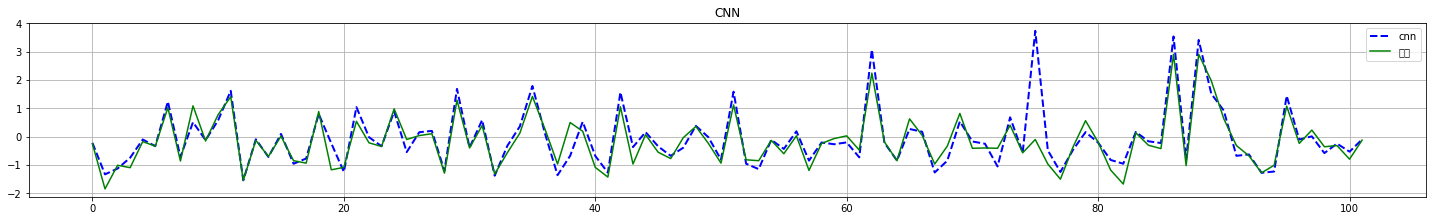

In [40]:
# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 16]) #原始資料的維度: 16
ys = tf.placeholder(tf.float32, [None, 1]) #輸出資料的維度: 1

keep_prob = tf.placeholder(tf.float32) #dropout的比例

x_image = tf.reshape(xs, [-1, 4, 4, 1]) #原始資料16轉成二維圖片4*4
## conv1 layer
w_conv1 = weight_variable([2, 2, 1, 32]) # patch 2x2, in size 1, out size 32, 每個像素變成32個像素->變厚
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1) #output size 2x2x32

## conv2 layer
w_conv2 = weight_variable([2, 2, 32, 64]) # patch 2x2, in size 32, out size 64, 每個像素變成64個像素->變厚
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2) + b_conv2) #output size 4x4x64

## fc1 layer
w_fc1 = weight_variable([4 * 4 * 64, 512]) # 4 x 4, 高度64的三維圖片, 拉平成512長的一維數值
b_fc1 = bias_variable([512])

h_pool2_flat = tf.reshape(h_conv2, [-1, 4 * 4 * 64]) # 4 x 4, 高度64的三維圖片, 拉平成512長的一維數值
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) # dropout 比例為keep_prob的元素

## fc2 layer
w_fc2 = weight_variable([512, 1]) #512長的一維數值壓縮成長度為1的數值
b_fc2 = bias_variable([1]) #bias

# result
prediction = tf.matmul(h_fc1_drop, w_fc2) + b_fc2

# 計算 predition與y差距->suare()平方, sum()求和, mean()平均值
cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction), reduction_indices=[1]))

# 0.01學習效率, minimize(loss)減小loss誤差
train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

sess = tf.Session()

sess.run(tf.global_variables_initializer())

#訓練500次
for i in range(200):
    sess.run(train_step, feed_dict={xs: train_x_disorder, ys: train_y_disorder, keep_prob: 0.7})
    print(i, '誤差=', sess.run(cross_entropy, feed_dict={xs: train_x_disorder, ys: train_y_disorder, keep_prob: 1.0})) #output loss

#可視化
prediction_value = sess.run(prediction, feed_dict={xs: test_x_disorder, ys:test_y_disorder, keep_prob: 1.0})
#畫圖
fig = plt.figure(figsize=(20, 3)) #dpi參數指定繪圖對象的分辨率，即每英吋多少個像素，缺省值為80
axes = fig.add_subplot(1, 1, 1)
line1, = axes.plot(range(len(prediction_value)), prediction_value, 'b--', label='cnn', linewidth=2)
line3, = axes.plot(range(len(test_y_disorder)), test_y_disorder, 'g', label='實際')

axes.grid()
fig.tight_layout()
plt.legend(handles=[line1, line3])
plt.title('CNN')
plt.show()

# RNN

In [41]:
boston = load_boston()
x = boston.data
y = boston.target

print('x:', x.shape)
print('y:', y.shape)

ss_x2 = sklearn.preprocessing.StandardScaler()
train_x2 = ss_x2.fit_transform(x)

ss_y2 = sklearn.preprocessing.StandardScaler()
train_y2 = ss_y2.fit_transform(y.reshape(-1, 1))

x: (506, 13)
y: (506,)


In [42]:
BATCH_START = 0 # 建立 batch data 時的index
TIME_STEPS = 10 # backpropagation through time 的 time steps
BATCH_SIZE = 30
INPUT_SIZE = 13 # sin數據輸出size
OUTPUT_SIZE = 1 # cos數據輸出size
CELL_SIZE = 10 # RNN的hidden unit size
LR = 0.006 # learning rate

def get_batch_boston():
    global train_x2, train_y2, BATCH_START, TIME_STEPS
    x_part1 = train_x2[BATCH_START : BATCH_START + TIME_STEPS * BATCH_SIZE]
    y_part1 = train_y2[BATCH_START : BATCH_START + TIME_STEPS * BATCH_SIZE]
    print('時間段=', BATCH_START, BATCH_START + TIME_STEPS * BATCH_SIZE)

    seq = x_part1.reshape((BATCH_SIZE, TIME_STEPS, INPUT_SIZE))
    res = y_part1.reshape((BATCH_SIZE, TIME_STEPS, 1))

    BATCH_START += TIME_STEPS

    # returned seq, res and xs: shape (batch, step, input)
    # np.newaxis 用來增加一個維度，變成三維，第三個維度用來存上一批樣本的狀態
    return [seq, res]

In [43]:
def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = npu.arange(BATCH_START, BATCH_START+TIME_STEPS * BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10 * np.pi)
    print('xs.shape=', xs.shape)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS

    # 畫圖
    plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], 'b--')
    plt.show()

    print('增加維度前:', seq.shape)
    print(seq[ :2])
    print('增加維度後:', seq[ :, :, np.newaxis].shape)
    print(seq[ :2])
    # returned seq, res and xs: shape(batch, step, input)
    # np.newaxis 用來增加一個維度，變成三維，第三個維度用來存上一批樣本的狀態
    return [seq[ :, :, np.newaxis], res[ :, :, np.newaxis], xs]

In [44]:
class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        '''
        n_steps: 每批數值總共含多少時間刻度
        input_size: 輸入數值的維度
        output_size: 輸出數值的維度 如果是類似價格曲線的話 應該為1
        cell_size: cell的大小
        batch_size: 每批次訓練數值的數量
        '''
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size

        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs') #xs 有三個維度
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys') #xs 有三個維度

        with tf.variable_scope('in_hidden'):
            self.add_input_layer()

        with tf.variable_scope('LSTM_cell'):
            self.add_cell()

        with tf.variable_scope('out_hidden'):
            self.add_output_layer()

        with tf.name_scope('cost'):
            self.compute_cost()

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)

    # 增加一個輸入層
    def add_input_layer(self):
        # 1_in_x: (batch * n_step, in_size), 相當於把這個批次的樣本串到一個長度1000的時間線上，每批次50個樣本，每個樣本20時刻
        l_in_x = tf.reshape(self.xs, [-1, self.input_size], name='2_2D') #-1 表示任意行數
        # ws(in_size, cell_size)
        ws_in = self._weight_variable([self.input_size, self.cell_size])
        # bs(cell_size, )
        bs_in = self._bias_variable([self.cell_size])
        # l_in_y = (batch * n_steps, cell_size)
        with tf.name_scope('wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, ws_in) + bs_in
        # reshape l_in_y ==> (batch, n_steps, cell_size)
        self.l_in_y = tf.reshape(l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')

    # 多時刻的狀態疊加層
    def add_cell(self):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(self.cell_size, forget_bias = 1.0, state_is_tuple = True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size, dtype = tf.float32)
        # time_major = False 表示時間主線不是第一列batch
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(lstm_cell, self.l_in_y, initial_state =               self.cell_init_state, time_major = False)

    #增加一個輸出層
    def add_output_layer(self):
        # shape = (batch * steps, cell_size)
        l_out_x = tf.reshape(self.cell_outputs, [-1, self.cell_size], name = '2_2D')
        ws_out = self._weight_variable([self.cell_size, self.output_size])
        bs_out = self._bias_variable([self.output_size, ])
        # shape = (batch * steps, output_size)
        with tf.name_scope('wx_plus_b'):
            self.pred = tf.matmul(l_out_x, ws_out) + bs_out #預測結果

    def compute_cost(self):
        losses = seq_loss.sequence_loss_by_example(
            [tf.reshape(self.pred, [-1], name='reshape_pred')],
            [tf.reshape(self.ys, [-1], name='reshape_target')],
            [tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
            average_across_timesteps=True,
            softmax_loss_function = self.msr_error,
            name = 'losses'
        )
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(losses, name = 'losses_sum'),
                self.batch_size,
                name = 'average_cost'
            )
            tf.summary.scalar('cost', self.cost)

    def ms_error(self, y_pre, y_target):
        return tf.square(tf.sub(y_pre, y_target))

    def msr_error(self, logits, labels):
        return tf.square(tf.subtract(logits, labels))

    def _weight_variable(self, shape, name = 'weights'):
        initializer = tf.random_normal_initializer(mean = 0., stddev = 1., )
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name = 'biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)

 30 330
時間段= 40 340
時間段= 50 350
時間段= 60 360
時間段= 70 370
時間段= 80 380
時間段= 90 390
時間段= 100 400
時間段= 110 410
時間段= 120 420
時間段= 130 430
時間段= 140 440
時間段= 150 450
時間段= 160 460
時間段= 170 470
時間段= 180 480
時間段= 190 490
125 cose:  0.0892
時間段= 0 300
時間段= 10 310
時間段= 20 320
時間段= 30 330
時間段= 40 340
時間段= 50 350
時間段= 60 360
時間段= 70 370
時間段= 80 380
時間段= 90 390
時間段= 100 400
時間段= 110 410
時間段= 120 420
時間段= 130 430
時間段= 140 440
時間段= 150 450
時間段= 160 460
時間段= 170 470
時間段= 180 480
時間段= 190 490
126 cose:  0.07
時間段= 0 300
時間段= 10 310
時間段= 20 320
時間段= 30 330
時間段= 40 340
時間段= 50 350
時間段= 60 360
時間段= 70 370
時間段= 80 380
時間段= 90 390
時間段= 100 400
時間段= 110 410
時間段= 120 420
時間段= 130 430
時間段= 140 440
時間段= 150 450
時間段= 160 460
時間段= 170 470
時間段= 180 480
時間段= 190 490
127 cose:  0.0863
時間段= 0 300
時間段= 10 310
時間段= 20 320
時間段= 30 330
時間段= 40 340
時間段= 50 350
時間段= 60 360
時間段= 70 370
時間段= 80 380
時間段= 90 390
時間段= 100 400
時間段= 110 410
時間段= 120 420
時間段= 130 430
時間段= 140 440
時間段= 150 450
時間段= 160 460
時間段= 170 470
時間段= 180 480
時間段=

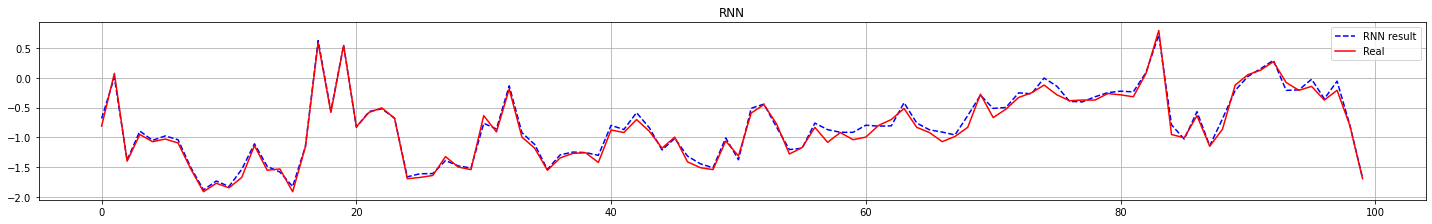

In [45]:
if __name__ == '__main__':
    seq, res = get_batch_boston()

    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    sess = tf.Session()
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs", sess.graph)
    sess.run(tf.global_variables_initializer())

    # relocate to the local dir and run this line to view it on http://0.0.0.0:6006/
    #$tensorboard --logdir = 'logs'

    # 訓練200次
    for j in range(200):
        pred_res = None
        for i in range(20): #把整個數值分為20個時間段
            seq, res = get_batch_boston()

            if i == 0:
                feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    # create initial state
                }
            else:
                feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    model.cell_init_state: state
                    # use last state as the initial state for this run
                }

            _, cost, state, pred = sess.run(
                [model.train_op, model.cost, model.cell_final_state, model.pred],
                feed_dict = feed_dict
            )
            pred_res = pred
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)
        print('{0} cose: '.format(j ), round(cost, 4))
        BATCH_START = 0 # 從頭再來一遍

    # 畫圖
    print('result:', pred_res.shape)

    # 與最後一次訓練所用的數值保持一致
    train_y2 = train_y2[190: 490]
    print('實際', train_y2.flatten().shape)

    r_size = BATCH_SIZE * TIME_STEPS

    # 畫圖
    fig = plt.figure(figsize = (20, 3)) # dpi參數指定繪圖對象的分辨率，即每英吋多少個像素，缺省值為80
    axes = fig.add_subplot(1, 1, 1)
    # 為了方便看，只顯示了後100行數據
    line1, = axes.plot(range(100), pred.flatten()[-100:], 'b--', label = 'RNN result')
    #line2, = axes.plot(range(len(gbr_pridict)), gbr_pridict, 'r--', label = '優化參數')
    line3, = axes.plot(range(100), train_y2.flatten()[-100:], 'r', label = 'Real')

    axes.grid()
    fig.tight_layout()
    #plt.legend(handles = [line1, line2, line3])
    plt.legend(handles = [line1, line3])
    plt.title('RNN')
    plt.show()